# Практическое задание по занятию Denosing Diffusional Models

ФИО: Мушенко Егор Сергеевич

# Задание

0) Скачайте репозиторий git clone https://github.com/awjuliani/pytorch-diffusion.git

1) Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

2) Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance https://arxiv.org/abs/2207.12598. (1 балл)

3) Обучите модель в режиме inpainting. Параграф 4.1 в https://arxiv.org/pdf/2201.09865.pdf . (1 балл)


In [1]:
! git clone https://github.com/awjuliani/pytorch-diffusion.git

fatal: destination path 'pytorch-diffusion' already exists and is not an empty directory.


In [2]:
%cd pytorch-diffusion

/content/pytorch-diffusion


In [3]:
! pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader
import imageio
import glob
import matplotlib.pyplot as plt
import torchvision

In [5]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = 10
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1


In [6]:
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [7]:
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    logger=tb_logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name  | Type       | Params
--------------------------------------
0  | inc   | DoubleConv | 37.7 K
1  | down1 | Down       | 295 K 
2  | down2 | Down       | 1.2 M 
3  | down3 | Down       | 2.4 M 
4  | up1   | Up         | 6.2 M 
5  | up2   | Up         | 1.5 M 
6  | up3   | Up         | 406 K 
7  | outc  | OutConv    | 65    
8  | sa1   | SAWrapper  | 395 K 
9  | sa2   | SAWrapper  | 395 K 
10 | sa3   | SAWrapper  | 99.6 K
--------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [10]:
gen_samples = []
for i in range(5):
    samples = []
    torch.manual_seed(i)
    x = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    for t in sample_steps:
        x = model.denoise_sample(x, t)
        if t % 50 == 0:
            samples.append(x)
    gen_samples.append(samples)

In [11]:
len(gen_samples)

5

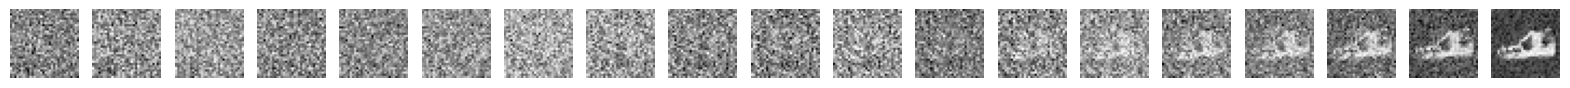

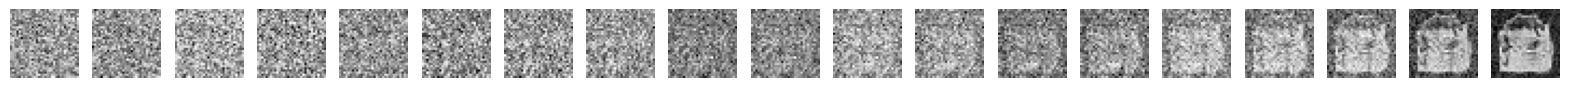

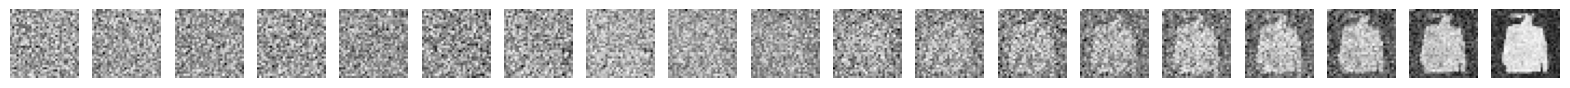

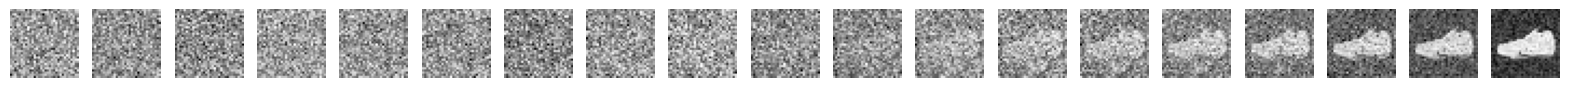

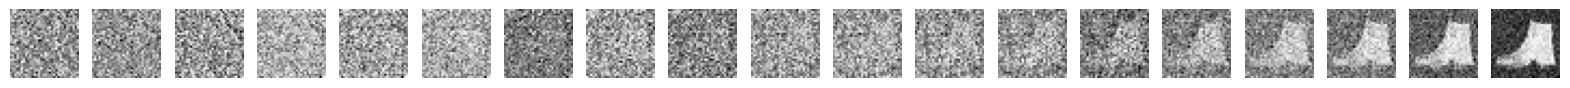

In [12]:
for samples in gen_samples:
    plt.figure(figsize=(20, 3))
    for i, sample in enumerate(samples):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(sample.detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
        plt.axis('off')
    plt.show()

In [13]:
import numpy as np
from torch import nn
import math

In [14]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision import transforms

In [15]:
class ConditionDiffSet(DiffSet):
    def __init__(self, train, dataset="MNIST"):
        super(ConditionDiffSet, self).__init__(train, dataset=dataset)
        datasets = {
            "MNIST": MNIST,
            "Fashion": FashionMNIST,
            "CIFAR": CIFAR10,
        }

        train_dataset = datasets[dataset](
            "./data", download=True, train=train
        )
        self.labels = train_dataset.targets
    
    def __getitem__(self, item):
        return self.input_seq[item], self.labels[item]

In [16]:
class ConditionDiffusionModel(DiffusionModel):
    def __init__(self, in_size, t_range, img_d, num_classes=10, time_dim=256):
        super().__init__(in_size, t_range, img_d)
        self.time_dim=time_dim
        self.label_emb = nn.Embedding(num_classes, self.time_dim)

    def forward(self, x, t, y=None):
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16) + self.pos_encoding(y, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8) + self.pos_encoding(y, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4) + self.pos_encoding(y, 256, 4)
        x4 = self.sa2(x4)

        
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8) + self.pos_encoding(y, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16) + self.pos_encoding(y, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32) + self.pos_encoding(y, 64, 32)
        output = self.outc(x)
        return output

    def get_loss(self, batch, batch_idx):
        p_cond = 0.5
        x, y = batch
        y = y*torch.ones_like(y).bernoulli(p_cond)

        ts = torch.randint(0, self.t_range, [x.shape[0]], device=self.device)
        noise_imgs = []
        epsilons = torch.randn(x.shape, device=self.device)
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append(
                (math.sqrt(a_hat) * x[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float), y.unsqueeze(-1).type(torch.float))
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss
    
    def denoise_sample(self, x, t, y=None):
        with torch.no_grad():
            if t > 1:
                z = torch.randn(x.shape)
            else:
                z = 0
            e_hat = self.forward(x, t.type(torch.float), y.unsqueeze(-1).type(torch.float)) + self.forward(x, t.type(torch.float), torch.tensor(0).unsqueeze(-1).type(torch.float))

            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

In [17]:
train_dataset = ConditionDiffSet(True, dataset_choice)
val_dataset = ConditionDiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [18]:
conditional_model = ConditionDiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, 1, 10)

In [19]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    logger=tb_logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(conditional_model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type       | Params
------------------------------------------
0  | inc       | DoubleConv | 37.7 K
1  | down1     | Down       | 295 K 
2  | down2     | Down       | 1.2 M 
3  | down3     | Down       | 2.4 M 
4  | up1       | Up         | 6.2 M 
5  | up2       | Up         | 1.5 M 
6  | up3       | Up         | 406 K 
7  | outc      | OutConv    | 65    
8  | sa1       | SAWrapper  | 395 K 
9  | sa2       | SAWrapper  | 395 K 
10 | sa3       | SAWrapper  | 99.6 K
11 | label_emb | Embedding  | 2.6 K 
------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.686    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [21]:
from tqdm.notebook import tqdm

In [22]:
conditional_model.to("cpu")

ConditionDiffusionModel(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GroupNorm(1, 64, eps=1e-05, affine=True)
        )
      )
      (2): DoubleConv(
        (double_conv): S

In [23]:
x = torch.randn((16, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(conditional_model.t_range-1, 0, -1)
for t in tqdm(sample_steps):
    x = conditional_model.denoise_sample(x, t, torch.ones(16))

  0%|          | 0/999 [00:00<?, ?it/s]

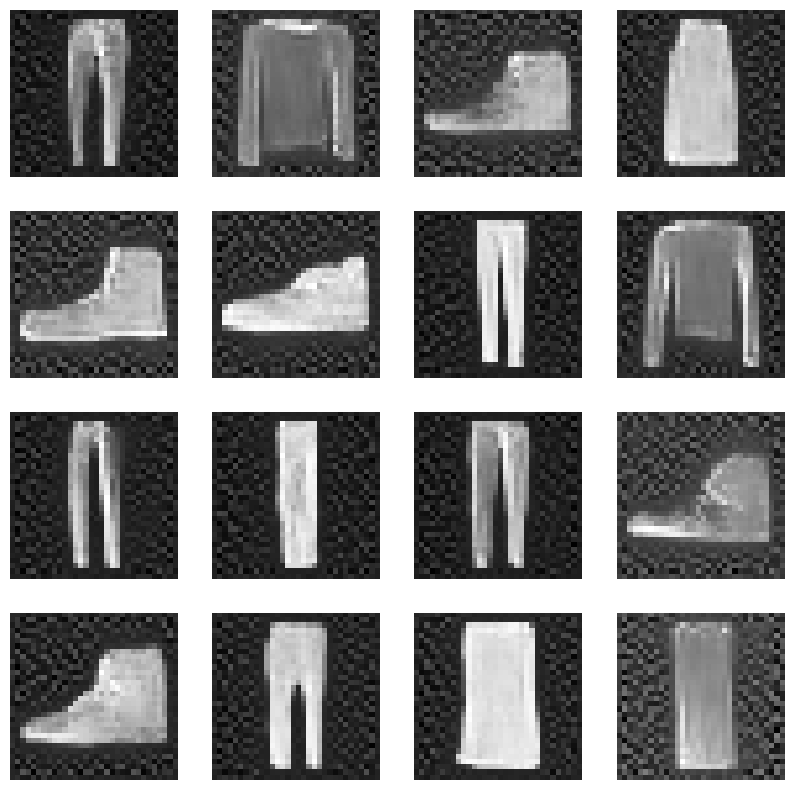

In [24]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x[i].detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
    plt.axis('off')


In [25]:
images = train_dataset[:5]

In [26]:
mask = torch.ones(32, 32)
mask[10:20, 10:20] = torch.zeros(10, 10)

In [27]:
resampling = 5

In [28]:
from tqdm import *

In [29]:
model.to("cpu")

DiffusionModel(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GroupNorm(1, 64, eps=1e-05, affine=True)
        )
      )
      (2): DoubleConv(
        (double_conv): Sequential

In [30]:
import numpy as np

In [31]:
from tqdm import std
from numpy.ma.core import mean
gen_samples = []
for image in images:
    image = image[0].unsqueeze(0)
    samples = []
    x = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    for t in tqdm(sample_steps):
      for u in range(resampling):
        a_bar = model.alpha_bar(t)
        b_t = model.beta(t)
        e = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size))
        x_known = np.sqrt(a_bar)*image + (1-a_bar)*e
        x_uknown = model.denoise_sample(x, t)

        x = mask * x_known + (1-mask) * x_uknown
        if t > 0 and u < resampling-1:
          x = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size)) * model.beta(t)*torch.ones_like(x) + torch.sqrt(1-model.beta(t))*x
      if t % 50 == 0:
        samples.append(x)
    gen_samples.append(samples)

100%|██████████| 999/999 [05:27<00:00,  3.05it/s]


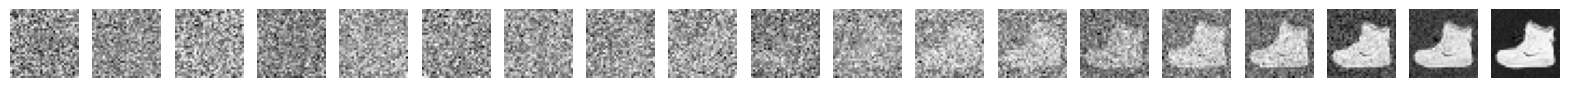

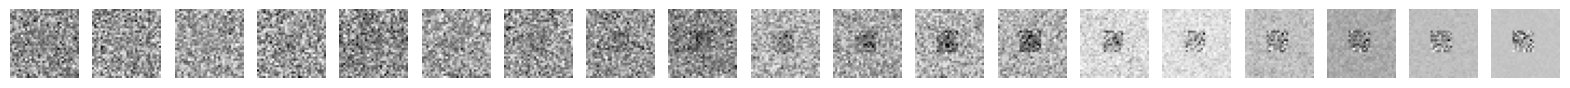

In [32]:
for samples in gen_samples:
    plt.figure(figsize=(20, 3))
    for i, sample in enumerate(samples):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(sample.detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
        plt.axis('off')
    plt.show()

Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: